In [2]:
## Packages
import numpy as np
import xarray as xr
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'sans'
# mpl.rcParams['mathtext.it'] = 'sans:italic'
# mpl.rcParams['mathtext.default'] = 'it'
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
import pandas as pd
from scipy import integrate
from scipy import stats
from datetime import timedelta
from cftime import DatetimeNoLeap

In [3]:
## Test names
cri240 = 'cri240K_test'
cri263 = 'cri263K_test'
cri273 = 'cri273K_test'
control = 'tutorial'

## Filepaths
path_to_cri240_data = '/Users/ash/Documents/scam1.2/work/cases/'+cri240+'.FSCAM.mpace/run/'+cri240+'.FSCAM.mpace.cam.h0.2004-10-05-07171.nc'
path_to_cri263_data = '/Users/ash/Documents/scam1.2/work/cases/'+cri263+'.FSCAM.mpace/run/'+cri263+'.FSCAM.mpace.cam.h0.2004-10-05-07171.nc'
path_to_cri273_data = '/Users/ash/Documents/scam1.2/work/cases/'+cri273+'.FSCAM.mpace/run/'+cri273+'.FSCAM.mpace.cam.h0.2004-10-05-07171.nc'
path_to_mpace_data = '/Users/ash/Documents/scam1.2/work/cases/'+control+'.FSCAM.mpace/run/'+control+'.FSCAM.mpace.cam.h0.2004-10-05-07171.nc'
path_to_graphs = '/Users/ash/Documents/scam1.2/work/graphs/corrected_optics/'

In [4]:
## Load data
cri240_data = xr.open_dataset(path_to_cri240_data)
cri263_data = xr.open_dataset(path_to_cri263_data)
cri273_data = xr.open_dataset(path_to_cri273_data)
mpace_data = xr.open_dataset(path_to_mpace_data)

In [5]:
def addgeopotential(ds):
    # Add avg geopotential height as a coordinate
    z_avg = np.squeeze(ds.Z3.mean(dim='time').values)
    ds = ds.assign_coords(height=('lev',z_avg))

    top_km = z_avg[14]/1000
    bottom_km = z_avg[-1]/1000

    return ds,top_km,bottom_km

In [6]:
def add_cloudspecies(ds):
    # Add dominant cloud species
    '''
    0: no cloud
    1: ice
    2: non-supercooled liquid
    3: supercooled liquid
    '''

    cloud_species = np.full_like(ds.FREQI.values,0)
    SL_index = ds.T.values > 273.15

    liq_ds = ds.CLDLIQ.values
    SL_ds = np.where(SL_index,0,liq_ds)
    non_SL_ds = np.where(SL_index,liq_ds,0)
    ice_ds = ds.CLDICE.values

    ice_only = ice_ds > liq_ds
    cloud_species[ice_only] = 1
    SL_only = SL_ds > ice_ds
    cloud_species[SL_only] = 3
    non_SL_only = non_SL_ds > ice_ds
    cloud_species[non_SL_only] = 2
    no_cloud = ds.CLOUD.values == 0
    cloud_species[no_cloud] = 0

    cloud_species_da = xr.DataArray(data=cloud_species,
                                   dims=['time','lev','lat','lon'],
                                   coords=dict(
                                       time=(['time'],ds.time.values),
                                       lev=(['lev'],ds.lev.values),
                                       lat=(['lat'],ds.lat.values),
                                       lon=(['lon'],ds.lon.values)),
                                   name='cloud_species',
                                   attrs={'long_name':'Dominant cloud species','units':'0 = no cloud; 1 = ice; 2 = non-supercooled liquid; 3 = supercooled-liquid'})
    
    ds['cloud_species'] = cloud_species_da

    return ds

In [50]:
def lowest_cloud_SL_FLDS(ds):
    cloud_only = np.squeeze(ds.cloud_species.where(np.logical_and(ds.cloud_species != 0,ds.FLDS != 0), drop=True).values)
    cloud_only_FLDS = np.squeeze(ds.FLDS.where(ds.FLDS != 0, drop=True).values)
    opt_depth = np.squeeze(ds.TOT_CLD_VISTAU.where(ds.TOT_CLD_VISTAU != 0, drop=True).sum('lev').values)

    SL_only_FLDS = []

    a,b = cloud_only.shape
    for i in range(0,a):
        cloud_only_no_nan = cloud_only[i][~np.isnan(cloud_only[i,:])]

        if (cloud_only_no_nan[-1] == 3) and (opt_depth[i] < 5):
        #if cloud_only_no_nan[-1] == 3:
            SL_only_FLDS.append(cloud_only_FLDS[i])

    SL_only_FLDS = np.array(SL_only_FLDS)

    return SL_only_FLDS
            

In [8]:
def add_summed_spectral_fluxes(ds):
    # Add LW
    ds['LD_bd_surf'] = ds.LD.sum('lw_band')[dict(lev=31)]
    ds['LU_bd_TOA'] = ds.LU.sum('lw_band')[dict(lev=0)]
    ds['LD_LU_net_surf'] = ds.LU.sum('lw_band')[dict(lev=31)]-ds.LD.sum('lw_band')[dict(lev=31)]
    ds['LD_LU_net_TOA'] = ds.LU.sum('lw_band')[dict(lev=0)]-ds.LD.sum('lw_band')[dict(lev=0)]

    # Add SW
    ds['SD_bd_surf'] = ds.SD.sum('sw_band')[dict(lev=31)]
    ds['SU_bd_TOA'] = ds.SU.sum('sw_band')[dict(lev=0)]
    ds['SD_SU_net_surf'] = ds.SD.sum('sw_band')[dict(lev=31)]-ds.SU.sum('sw_band')[dict(lev=31)]
    ds['SD_SU_net_TOA'] = ds.SD.sum('sw_band')[dict(lev=0)]-ds.SU.sum('sw_band')[dict(lev=0)]

    return ds

In [9]:
## Modify datasets
# Add avg geopotential height as a coordinate
cri240_data,zcri240_up_km,zcri240_dn_km = addgeopotential(cri240_data)
cri263_data,zcri263_up_km,zcri263_dn_km = addgeopotential(cri263_data)
cri273_data,zcri273_up_km,zcri273_dn_km = addgeopotential(cri273_data)
mpace_data,zmpace_up_km,zmpace_dn_km = addgeopotential(mpace_data)

In [10]:
# Add cloud species
cri240_data = add_cloudspecies(cri240_data)
cri263_data = add_cloudspecies(cri263_data)
cri273_data = add_cloudspecies(cri273_data)
mpace_data = add_cloudspecies(mpace_data)

/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_20835/894569858.py:5: UserWarning: The figure layout has changed to tight
  fig9.tight_layout(pad=2.5)


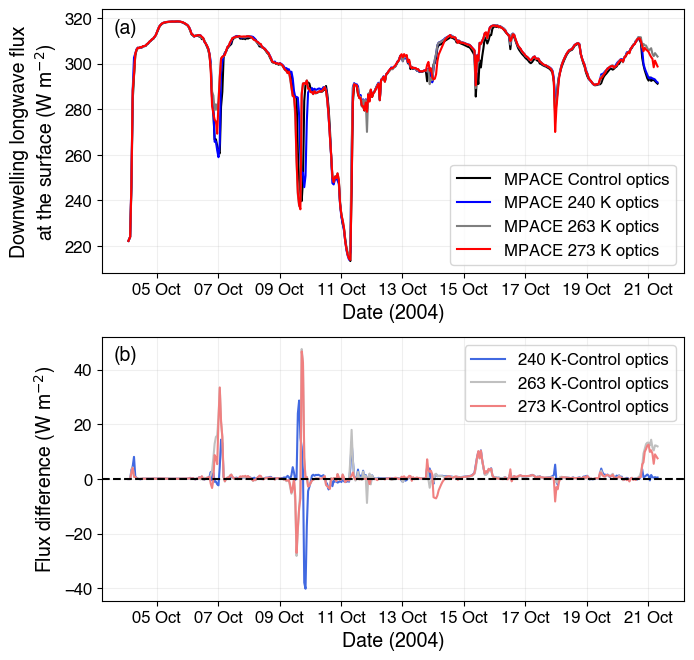

In [15]:
## Plot downwelling LW flux (FLDS) at the surface
# Set up
fig9, axlist9 = plt.subplots(2,1,layout='constrained')
fig9.set_size_inches(6.9,6.9)
fig9.tight_layout(pad=2.5)

# Plot
mpace_data.FLDS.where(mpace_data.FLDS != 0,drop=True).plot(ax=axlist9[0],x='time',color='k',label='MPACE Control optics')
cri240_data.FLDS.where(cri240_data.FLDS != 0,drop=True).plot(ax=axlist9[0],x='time',color='b',label='MPACE 240 K optics')
cri263_data.FLDS.where(cri263_data.FLDS != 0,drop=True).plot(ax=axlist9[0],x='time',color='tab:gray',label='MPACE 263 K optics')
cri273_data.FLDS.where(cri273_data.FLDS != 0,drop=True).plot(ax=axlist9[0],x='time',color='r',label='MPACE 273 K optics')

(cri240_data.FLDS.where(mpace_data.FLDS != 0,drop=True)-mpace_data.FLDS.where(mpace_data.FLDS != 0,drop=True)).plot(ax=axlist9[1],x='time',color='royalblue',label='240 K-Control optics')
(cri263_data.FLDS.where(mpace_data.FLDS != 0,drop=True)-mpace_data.FLDS.where(mpace_data.FLDS != 0,drop=True)).plot(ax=axlist9[1],x='time',color='silver',label='263 K-Control optics')
(cri273_data.FLDS.where(mpace_data.FLDS != 0,drop=True)-mpace_data.FLDS.where(mpace_data.FLDS != 0,drop=True)).plot(ax=axlist9[1],x='time',color='lightcoral',label='273 K-Control optics')
axlist9[1].axhline(0,ls='--',color='k')

# Formatting
# Process xticks
xticks = np.unique(mpace_data.time.dt.round("2D"))

axlist9[0].set_title('')
axlist9[0].set_ylabel('Downwelling longwave flux\nat the surface (W m$^{-2}$)',fontsize=14)
axlist9[0].set_xlabel('Date (2004)',fontsize=14)
axlist9[0].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
axlist9[0].set_xticks(xticks)
axlist9[0].tick_params(labelsize=12)
axlist9[0].legend(fontsize='12')
axlist9[0].grid(alpha=0.2)
axlist9[0].text(0.02,0.91,'(a)',fontsize=14,transform=axlist9[0].transAxes)

axlist9[1].set_title('')
axlist9[1].set_ylabel('Flux difference (W m$^{-2}$)',fontsize=14)
axlist9[1].set_xlabel('Date (2004)',fontsize=14)
axlist9[1].xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
axlist9[1].set_xticks(xticks)
axlist9[1].tick_params(labelsize=12)
axlist9[1].legend(fontsize='12')
axlist9[1].grid(alpha=0.2)
axlist9[1].text(0.02,0.91,'(b)',fontsize=14,transform=axlist9[1].transAxes)


fig9.savefig(path_to_graphs+'DownLW_surf_all.pdf',bbox_inches='tight',dpi=400)
#plt.close(fig9)

In [51]:
mpace_SL_FLDS = lowest_cloud_SL_FLDS(mpace_data)
cri240_SL_FLDS = lowest_cloud_SL_FLDS(cri240_data)
cri263_SL_FLDS = lowest_cloud_SL_FLDS(cri263_data)
cri273_SL_FLDS = lowest_cloud_SL_FLDS(cri273_data)

In [52]:
# Calculate medians and CIs
med_MP_SL_FLDS = np.median(mpace_SL_FLDS)
CI_MP_SL_FLDS = stats.mstats.median_cihs(mpace_SL_FLDS,alpha=0.05)

med_240_SL_FLDS = np.median(cri240_SL_FLDS)
CI_240_SL_FLDS = stats.mstats.median_cihs(cri240_SL_FLDS,alpha=0.05)

med_263_SL_FLDS = np.median(cri263_SL_FLDS)
CI_263_SL_FLDS = stats.mstats.median_cihs(cri263_SL_FLDS,alpha=0.05)

med_273_SL_FLDS = np.median(cri273_SL_FLDS)
CI_273_SL_FLDS = stats.mstats.median_cihs(cri273_SL_FLDS,alpha=0.05)

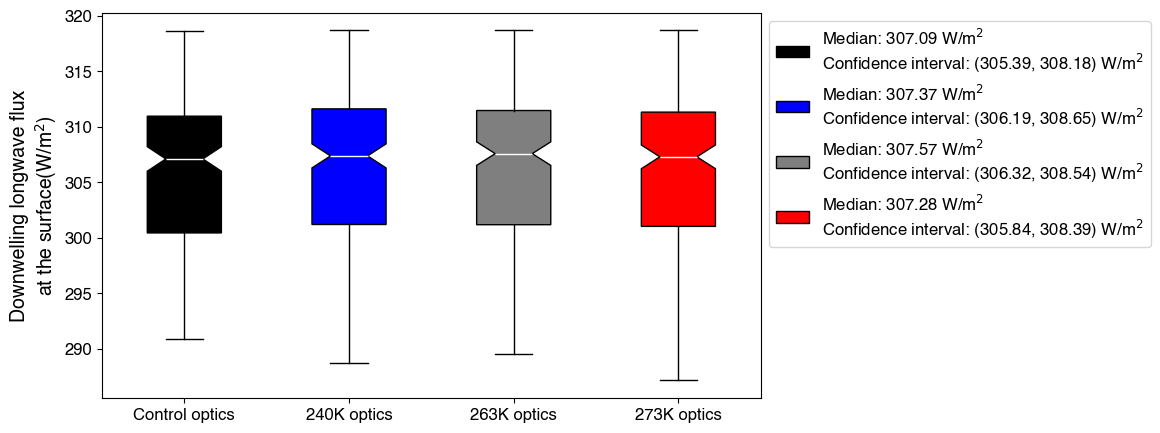

In [53]:
## Plot downwelling LW flux (FLDS) at the surface
# Set up
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8.5,5)

labels = ['Control optics','240K optics','263K optics','273K optics'] 


labels2 = ['Median: {:.2f} W/m$^2$\nConfidence interval: ({:.2f}, {:.2f}) W/m$^2$'.format(med_MP_SL_FLDS,CI_MP_SL_FLDS[0],CI_MP_SL_FLDS[1]),
          'Median: {:.2f} W/m$^2$\nConfidence interval: ({:.2f}, {:.2f}) W/m$^2$'.format(med_240_SL_FLDS,CI_240_SL_FLDS[0],CI_240_SL_FLDS[1]),
          'Median: {:.2f} W/m$^2$\nConfidence interval: ({:.2f}, {:.2f}) W/m$^2$'.format(med_263_SL_FLDS,CI_263_SL_FLDS[0],CI_263_SL_FLDS[1]),
          'Median: {:.2f} W/m$^2$\nConfidence interval: ({:.2f}, {:.2f}) W/m$^2$'.format(med_273_SL_FLDS,CI_273_SL_FLDS[0],CI_273_SL_FLDS[1])]

# Plot
bx = ax.boxplot([mpace_SL_FLDS,cri240_SL_FLDS,cri263_SL_FLDS,cri273_SL_FLDS],
                notch=True,showfliers=False,labels=labels,patch_artist=True,
                medianprops={'color':'w'})

# Formatting
colors=['k','b','tab:gray','r']
for patch,color in zip(bx['boxes'], colors):
    patch.set_facecolor(color)
ax.legend(bx['boxes'],labels2,loc='upper left',bbox_to_anchor=(1.0,1.00),fontsize=12)
ax.set_ylabel('Downwelling longwave flux\nat the surface(W/m$^{2}$)',fontsize=14)
ax.tick_params(labelsize=12)
#ax.set_title('Phase of lowest level cloud - supercooled liquid only')

fig.savefig(path_to_graphs+'DownLW_SL_only.png',bbox_inches='tight',dpi=400)
#plt.close(fig)